### Introduction: This is the Jupyter notebook to do the flowing things:

1. Read slimmed PKU Tree files
2. Store the raw MC histograms to pickle files

kernel:HWW(farm)/lpr(Cmsconnect)



### Import necessary modules

In [1]:
import numpy as np
import os
# import pandas as pd
import random
import awkward as ak
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
# from scipy import interpolate
# from sklearn.metrics import roc_curve, auc
from cycler import cycler
import uproot
# means uproot4
# import ROOT
import argparse
import glob
import json
import logging
import os
import pickle as pkl
import warnings

import hist as hist2
import pyarrow
# import utils #local file: utils.py
import yaml
from typing import Dict, List, Union
from dataclasses import dataclass, field
from copy import deepcopy

# from coffea import hist
from coffea.nanoevents import NanoEventsFactory, NanoAODSchema
from coffea.nanoevents.methods import vector
# from coffea.nanoevents.methods.vector import PtEtaPhiMLorentzVector

### Define templates dir

In [2]:
MAIN_DIR = "."

# plot_dir = f"{MAIN_DIR}/templates/12May2024_pdf_fixed"
plot_dir = f"{MAIN_DIR}/templates/v1_templ_24Jan2025"
_ = os.system(f"mkdir -p {plot_dir}")

### Read SlimmedTree files

In [3]:
# load the slimmedtree files using uproot
# if run on PKU cluster, use this:
CustNanoData = {
    'TT_Semilep'     : "/data/bond/zhaoyz/Pheno/slimmedtree/v9/TTbar.root",
    'WJets'          : "/data/bond/zhaoyz/Pheno/slimmedtree/v7/WJets.root",
}
files = { }
for typefile in CustNanoData:
    files[typefile] = uproot.lazy({CustNanoData[typefile]: "PKUTree"})

In [4]:
#gen-matching results: bkg

files["b_top_matched_bqq"] = files["TT_Semilep"][(files["TT_Semilep"]["top_matched_bqq"] == 1) & (files["TT_Semilep"]["isWcb"] == 0 )]
files["b_top_matched_bq"] = files["TT_Semilep"][(files["TT_Semilep"]["top_matched_bq"] == 1) & (files["TT_Semilep"]["isWcb"] == 0 )]
files["b_w_matched_others"] = files["TT_Semilep"][((files["TT_Semilep"]["w_matched_cd"] == 1) | (files["TT_Semilep"]["w_matched_cs"] == 1) | (files["TT_Semilep"]["w_matched_us"] == 1) | (files["TT_Semilep"]["w_matched_ud"] == 1) | (files["TT_Semilep"]["w_matched_ub"] == 1)) & (files["TT_Semilep"]["isWcb"] == 0) ]
files["b_w_matched_cb"] = files["TT_Semilep"][(files["TT_Semilep"]["w_matched_cb"] == 1) & (files["TT_Semilep"]["isWcb"] == 0)]
files["b_others"] = files["TT_Semilep"][((files["TT_Semilep"]["unmatched"] ==1) | (files["TT_Semilep"]["q_matched"] ==1) | (files["TT_Semilep"]["bb_matched"] ==1) | (files["TT_Semilep"]["b_matched_had"] ==1) | (files["TT_Semilep"]["b_matched_lep"] ==1) | (files["TT_Semilep"]["lep_b_qq"] ==1) | (files["TT_Semilep"]["lep_b_q"] ==1) | (files["TT_Semilep"]["bb_q"] ==1) | (files["TT_Semilep"]["bb_qq"] ==1)) & (files["TT_Semilep"]["isWcb"] == 0)]


files["s_top_matched_bqq"] = files["TT_Semilep"][(files["TT_Semilep"]["top_matched_bqq"]  ==1 ) & ( files["TT_Semilep"]["isWcb"] == 1)]
files["s_top_matched_bq"] = files["TT_Semilep"][(files["TT_Semilep"]["top_matched_bq"] == 1) & ( files["TT_Semilep"]["isWcb"] == 1)]
files["s_w_matched_others"] = files["TT_Semilep"][((files["TT_Semilep"]["w_matched_cd"] == 1) | (files["TT_Semilep"]["w_matched_cs"] == 1) | (files["TT_Semilep"]["w_matched_us"] == 1) | (files["TT_Semilep"]["w_matched_ud"] == 1) | (files["TT_Semilep"]["w_matched_ub"] == 1)) & (files["TT_Semilep"]["isWcb"] == 1) ]
files["s_w_matched_cb"] = files["TT_Semilep"][(files["TT_Semilep"]["w_matched_cb"] == 1) & ( files["TT_Semilep"]["isWcb"] ==1 )]
files["s_others"] = files["TT_Semilep"][((files["TT_Semilep"]["unmatched"] ==1) | (files["TT_Semilep"]["q_matched"] ==1) | (files["TT_Semilep"]["bb_matched"] ==1) | (files["TT_Semilep"]["b_matched_had"] ==1) | (files["TT_Semilep"]["b_matched_lep"] ==1) | (files["TT_Semilep"]["lep_b_qq"] ==1) | (files["TT_Semilep"]["lep_b_q"] ==1) | (files["TT_Semilep"]["bb_q"] ==1) | (files["TT_Semilep"]["bb_qq"] ==1)) & (files["TT_Semilep"]["isWcb"] == 1)]

files["TotalSignal"] = files["TT_Semilep"][( files["TT_Semilep"]["isWcb"] ==1 )]



### Add weight

In [5]:
for file in files:
    if file == "WJets":
        files[file]["weight"] = ak.ones_like(files[file]["hbc"])*15.92
    else:
        files[file]["weight"] = ak.ones_like(files[file]["hbc"])*100/97.5
    

In [6]:
def get_tagger(files, alpha = 0, beta = 0, name = ""):
    for sample in files:
        print(f"add tagger for {sample}")
        files[sample][name] = files[sample]["hbc"] / (files[sample]["hbc"] + alpha * files[sample]["qcd"] + beta * files[sample]["hbq"])

In [7]:
get_tagger(files, alpha = 1, beta = 0, name = "HbcvsQCD")

add tagger for TT_Semilep
add tagger for WJets
add tagger for b_top_matched_bqq
add tagger for b_top_matched_bq
add tagger for b_w_matched_others
add tagger for b_w_matched_cb
add tagger for b_others
add tagger for s_top_matched_bqq
add tagger for s_top_matched_bq
add tagger for s_w_matched_others
add tagger for s_w_matched_cb
add tagger for s_others
add tagger for TotalSignal


In [8]:
get_tagger(files, alpha = 0, beta = 1, name = "HbcvsHbq")

add tagger for TT_Semilep
add tagger for WJets
add tagger for b_top_matched_bqq
add tagger for b_top_matched_bq
add tagger for b_w_matched_others
add tagger for b_w_matched_cb
add tagger for b_others
add tagger for s_top_matched_bqq
add tagger for s_top_matched_bq
add tagger for s_w_matched_others
add tagger for s_w_matched_cb
add tagger for s_others
add tagger for TotalSignal


### some test about variables / output all the variables

In [9]:
files["TotalSignal"].fields

['PT_j',
 'Eta_j',
 'Phi_j',
 'Mass_j',
 'Mass_j_sd',
 'n_b_tight',
 'n_b_medium',
 'n_b_loose',
 'n_b_loose_1',
 'n_b_loose_2',
 'n_b_ideal',
 'delta_r_tight',
 'delta_r_medium',
 'delta_r_loose',
 'delta_r_loose_1',
 'delta_r_loose_2',
 'delta_r_ideal',
 'delta_r1_Wcb_tight',
 'delta_r1_Wcb_medium',
 'delta_r1_Wcb_loose',
 'delta_r1_Wcb_loose_1',
 'delta_r1_Wcb_loose_2',
 'delta_r1_Wcb_ideal',
 'delta_r2_Wcb_tight',
 'delta_r2_Wcb_medium',
 'delta_r2_Wcb_loose',
 'delta_r2_Wcb_loose_1',
 'delta_r2_Wcb_loose_2',
 'delta_r2_Wcb_ideal',
 'delta_r_max_b_Wcb_tight',
 'delta_r_max_b_Wcb_medium',
 'delta_r_max_b_Wcb_loose',
 'delta_r_max_b_Wcb_loose_1',
 'delta_r_max_b_Wcb_loose_2',
 'delta_r_max_b_Wcb_ideal',
 'delta_r_min_b_Wcb_tight',
 'delta_r_min_b_Wcb_medium',
 'delta_r_min_b_Wcb_loose',
 'delta_r_min_b_Wcb_loose_1',
 'delta_r_min_b_Wcb_loose_2',
 'delta_r_min_b_Wcb_ideal',
 'delta_eta_tight',
 'delta_eta_medium',
 'delta_eta_loose',
 'delta_eta_loose_1',
 'delta_eta_loose_2',
 'delta

### plot setting

In [10]:
import matplotlib as mpl
import matplotlib.pyplot as plt
import mplhep as hep
import boost_histogram as bh
from cycler import cycler

use_helvet = False ## true: use helvetica for plots, make sure the system have the font installed
if use_helvet:
    CMShelvet = hep.style.CMS
    CMShelvet['font.sans-serif'] = ['Helvetica', 'Arial']
    plt.style.use(CMShelvet)
else:
    plt.style.use(hep.style.CMS)

def flow(hist: bh.Histogram, overflow: bool=True, underflow: bool=True):
    h, var = hist.view(flow=(overflow | underflow)).value, hist.view(flow=(overflow | underflow)).variance
    if overflow: 
        # h, var also include underflow bins but in plots usually no underflow data
        # And we've filled None with -999, so we shouldn't show underflow data (mostly from filled None)
        # You have to access the overflow and underflow bins data like below:
        h[-2] += h[-1]; var[-2] += var[-1]
    if underflow:
        h[1] += h[0]; var[1] += var[0]
    if overflow or underflow:
        h, var = h[1:-1], var[1:-1]
    return h, var
    # Return the updated histogram and variance

def error_bar(h, var, type='data'):
    from scipy.interpolate import CubicSpline
    if type == 'data':
        number = h
    elif type == 'mc':  # h = k*N, var = k^2*N, std = k*sqrt(N)
        number = h**2 / var
    else:
        raise ValueError("type should be 'data' or 'mc'! ")
    center = range(11) # Number: 0-10
    up = np.array([1.84, 3.30, 4.64, 5.92, 7.16, 8.38, 9.58, 10.77, 11.95, 13.11, 14.27]) - center
    down = center - np.array([0, 0.17, 0.71, 1.37, 2.09, 2.84, 3.62, 4.42, 5.23, 6.06, 6.89])
    #cs means to create a CubicSpline object
    cs_up = CubicSpline(x=center, y=up)
    cs_down = CubicSpline(x=center, y=down)
    
    Garwood = (number>0)&(number<10)
    poison_error_bar = np.sqrt(number)
    up_error_bar = np.copy(poison_error_bar)
    down_error_bar = np.copy(poison_error_bar)
    up_error_bar[Garwood] = cs_up(number[Garwood])
    down_error_bar[Garwood] = cs_down(number[Garwood])
    if type == 'mc':
        up_error_bar *= var/h
        down_error_bar *= var/h
    up_error_bar [up_error_bar < 0 ] = 0
    down_error_bar [down_error_bar < 0 ] = 0
    return np.array([down_error_bar, up_error_bar])


# function to find the optimal region with S/sqrt(B)
# not used so far
def optimalcut(shist, bhist):
    n_bins = len(shist)
    best_lower = None
    best_upper = None
    best_s_sqrt_b = 0

    for lower in range(n_bins):
        for upper in range(lower+1, n_bins+1):
            s = np.sum(shist[lower:upper])
            b = np.sum(bhist[lower:upper])
            s_sqrt_b = s / np.sqrt(b + 1)

            if s_sqrt_b > best_s_sqrt_b:
                best_lower = lower
                best_upper = upper
                best_s_sqrt_b = s_sqrt_b

    return best_lower, best_upper, best_s_sqrt_b

def optimalcut_oneside(shist, bhist, epsilon = 0.01):
    '''
    Given the signal histogram and background histogram, 
    show the one-side cut for the variable to get best s/sqrt(b).
    Args:
        shist:signal histogram
        bhist:background histogram
        epsilon(float): epsilon to avoid numerical errs 
    '''
    n_bins = len(shist)
    best_cut = 0
    best_s_sqrt_b = 0

    for cut in range(n_bins):
        s = np.sum(shist[cut:])
        b = np.sum(bhist[cut:])
        s_sqrt_b = s / np.sqrt(b + epsilon)
        if s_sqrt_b > best_s_sqrt_b:
            best_cut = cut
            best_s_sqrt_b = s_sqrt_b
        
    return best_cut, best_s_sqrt_b

def optimalcut_mid_combine(shist1, shist2, bhist, epsilon = 1):
    '''
    Given the signal histogram and background histogram, 
    show the one-side cut for the variable to get best s/sqrt(b).
    Args:
        shist:signal histogram
        bhist:background histogram
        epsilon(float): epsilon to avoid numerical errs 
    '''
    n_bins = len(shist1)
    best_cut = 0
    best_combined_sig_two_side = 0

    for cut in range(n_bins):
        s_right_side = np.sum(shist2[cut:])
        b_right_side = np.sum(bhist[cut:])
        s_left_side = np.sum(shist1[:cut])
        b_left_side = np.sum(bhist[:cut])
        s_sqrt_b_right_side = s_right_side / np.sqrt(b_right_side + epsilon)
        s_sqrt_b_left_side = s_left_side / np.sqrt(b_left_side + epsilon)
        combined_sig_two_side = np.sqrt((s_sqrt_b_right_side)**2 + (s_sqrt_b_left_side)**2)
        if combined_sig_two_side > best_combined_sig_two_side:
            best_cut = cut
            best_combined_sig_two_side = combined_sig_two_side
        
    return best_cut, best_combined_sig_two_side


### Define observable object variables

In [11]:
from dataclasses import dataclass, field
from typing import List

@dataclass
class ShapeVar:
    """Class to store attributes of a variable to make a histogram of.

    Args:
        var (str): variable name
        label (str): variable label
        bins (List[int]): bins
        reg (bool, optional): Use a regular axis or variable binning. Defaults to True.
        blind_window (List[int], optional): if blinding, set min and max values to set 0. Defaults to None.
        significance_dir (str, optional): if plotting significance, which direction to plot it in.
          See more in plotting.py:ratioHistPlot(). Options are ["left", "right", "bin"]. Defaults to "right".
    """

    var: str = None
    label: str = None
    bins: List[int] = None
    reg: bool = True #regular axis
    blind_window: List[int] = None
    significance_dir: str = "right"

    def __post_init__(self):
        # create axis used for histogramming
        if self.reg:
            self.axis = hist2.axis.Regular(*self.bins, name=self.var, label=self.label)
        else:
            self.axis = hist2.axis.Variable(self.bins, name=self.var, label=self.label)

@dataclass
class Syst:
    samples: List[str] = None
    years: List[str] = field(default_factory=lambda: years)
    label: str = None
    
def blindBins(h: hist2.Hist, blind_region: List, blind_sample: str = None, axis=0):
    """
    Blind (i.e. zero) bins in histogram ``h``.
    If ``blind_sample`` specified, only blind that sample, else blinds all.
    """
    if axis > 0:
        raise Exception("not implemented > 1D blinding yet")

    bins = h.axes[axis + 1].edges
    lv = int(np.searchsorted(bins, blind_region[0], "right"))
    rv = int(np.searchsorted(bins, blind_region[1], "left") + 1)

    if blind_sample is not None:
        data_key_index = np.where(np.array(list(h.axes[0])) == blind_sample)[0][0]
        h.view(flow=True)[data_key_index][lv:rv].value = 0
        h.view(flow=True)[data_key_index][lv:rv].variance = 0
    else:
        h.view(flow=True)[:, lv:rv].value = 0
        h.view(flow=True)[:, lv:rv].variance = 0       
shape_vars = [
    ShapeVar(
        "MH_Reco",
        r"Wcb candidate soft-drop mass [GeV]",
        [20, 0, 200],
        reg=True,
        blind_window=[50, 110],
    )
]


### Define samples we consider

In [12]:
sig_keys = [
    "s_top_matched_bqq",
    "s_top_matched_bq",
    "s_w_matched_others",
    "s_w_matched_cb",
    "s_others",
    
    # bind together t->bq component with signal(s_* component) 
]

bkg_keys = [
    "b_top_matched_bqq",
    "b_top_matched_bq" 
    "b_w_matched_others",
    "b_w_matched_cb",
    "b_others",
    "WJets",
]

mc_keys = sig_keys + bkg_keys

### Define CUT(aka. regions)

In [13]:
CUT = {       
    "SR"   : {k:   (files[k]["HbcvsQCD"] >= 0.95) & (files[k]["n_b_loose"] == 2) & (files[k]["delta_r_loose"] > 1) & (files[k]["delta_r_min_b_Wcb_loose"] < 2) for k in files}, 
    }

### Save hist templates to pkl files

In [30]:
def save_pkl(files, path_str = plot_dir, template_file = "templates"):
    templates = {} #empty dict to store the templates file
    regions = ["SR",] #signal regions or control regions
    hist_samples = mc_keys + ["data"]
     
    print("now running templates:")
    #initialize weight based variation samples
    
    for region in regions:
        print("now processing:",region)
        templates[region] = hist2.Hist(
            hist2.axis.StrCategory(hist_samples, name="Sample"),
            *[shape_var.axis for shape_var in shape_vars],
            storage="weight",
            ) #initialize a hist object
        
        #add center value templates first
        for sample in hist_samples:
            if sample == "data":
                print(f"processing fake {sample}, all set to 0")
                data = files["b_top_matched_bqq"][CUT[region]["b_top_matched_bqq"]]
                print(data["Mass_j_sd"])
                templates[region].fill(
                                        Sample=sample,
                                        MH_Reco=ak.zeros_like(data["Mass_j_sd"]),
                                        weight=data["weight"],
                )
            else:
                print(f"processing {sample}")
                data = files[sample][CUT[region][sample]]
                print(data["Mass_j_sd"])
                templates[region].fill(
                                        Sample=sample,
                                        MH_Reco=data["Mass_j_sd"],
                                        weight=data["weight"],
                )

    #save files
    with open(f"{path_str}/{template_file}.pkl", "wb") as fp:
        pkl.dump(templates, fp) # dump the templates of each region in a pkl file
        print("Saved templates to", f"{template_file}.pkl")

In [31]:
save_pkl(files = files)

now running templates:
now processing: SR
processing s_top_matched_bqq
[]
processing s_top_matched_bq
[118, 74.2, 84.8, 72.8, 125, 88.4, 107, 104, 96.7]
processing s_w_matched_others
[]
processing s_w_matched_cb
[74.3, 55.4, 77.2, 66.5, 84.2, 76.5, 96.8, ... 77.8, 76.8, 91.1, 78.1, 107, 71.3]
processing s_others
[]
processing b_top_matched_bq
[107, 92.1, 110, 107, 121, 96.6, 82.2, 129, ... 65.3, 141, 99, 81.3, 94, 72.1, 91.1]
processing b_top_matched_bqq
[130, 119, 143, 142, 150, 164, 144, 132, ... 191, 90.5, 70, 142, 162, 132, 136, 179]
processing b_w_matched_others
[85.5, 87.2, 77.5, 89.2, 69.5, 76.8, 64.6, ... 76, 97.7, 150, 79.9, 83.8, 77.3, 77.5]
processing b_w_matched_cb
[]
processing b_others
[74.2, 95.6, 85.6, 53.7, 56.4, 123, 77.5, ... 74.4, 70.6, 60.5, 142, 58.1, 69.2, 59]
processing WJets
[]
processing fake data, all set to 0
[130, 119, 143, 142, 150, 164, 144, 132, ... 191, 90.5, 70, 142, 162, 132, 136, 179]
Saved templates to templates.pkl


In [16]:
PLACE_HOLDER

NameError: name 'PLACE_HOLDER' is not defined

In [ ]:
hists_template1

{'SR': Hist(
   StrCategory(['s_top_matched_bqq', 's_top_matched_bq', 's_w_matched_others', 's_w_matched_cb', 's_others', 'b_top_matched_bq', 'b_top_matched_bqq', 'b_w_matched_others', 'b_w_matched_cb', 'b_others', 'WJets'], name='Sample'),
   Regular(20, 0, 200, name='MH_Reco', label='Wcb candidate soft-drop mass [GeV]'),
   storage=Weight()) # Sum: WeightedSum(value=755.897, variance=775.279) (WeightedSum(value=760, variance=779.487) with flow)}

### test about the templates

In [32]:
with open(f"{plot_dir}/templates.pkl","rb") as f:
    hists_template1 = pkl.load(f)
hists_template1["SR"]["data",:]

Hist(Regular(20, 0, 200, name='MH_Reco', label='Wcb candidate soft-drop mass [GeV]'), storage=Weight()) # Sum: WeightedSum(value=63.5897, variance=65.2203)

### test how to load and use the *.pkl template file

In [23]:
def get_template(h, sample):
    ''' 
    histogram h Hist, with axes:["samples","systematic","MH_Reco"]
    sample is sample name in ["QCD",...,"data"]
    '''
    mass_axis = 1 #axis index
    massbins = h.axes[mass_axis].edges
    return (h[sample, :].values(), h[sample, :].variances(), massbins, "MH_Reco")

a = get_template(hists_template1["SR"],"s_w_matched_cb")
a

(array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         4.10256433,  7.17948759, 13.33333409,  7.17948759,  7.17948759,
         2.05128217,  1.02564108,  0.        ,  1.02564108,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]),
 array([ 0.        ,  0.        ,  0.        ,  0.        ,  0.        ,
         4.20775853,  7.36357743, 13.67521522,  7.36357743,  7.36357743,
         2.10387927,  1.05193963,  0.        ,  1.05193963,  0.        ,
         0.        ,  0.        ,  0.        ,  0.        ,  0.        ]),
 array([  0.,  10.,  20.,  30.,  40.,  50.,  60.,  70.,  80.,  90., 100.,
        110., 120., 130., 140., 150., 160., 170., 180., 190., 200.]),
 'MH_Reco')

### make some plots to test the variation

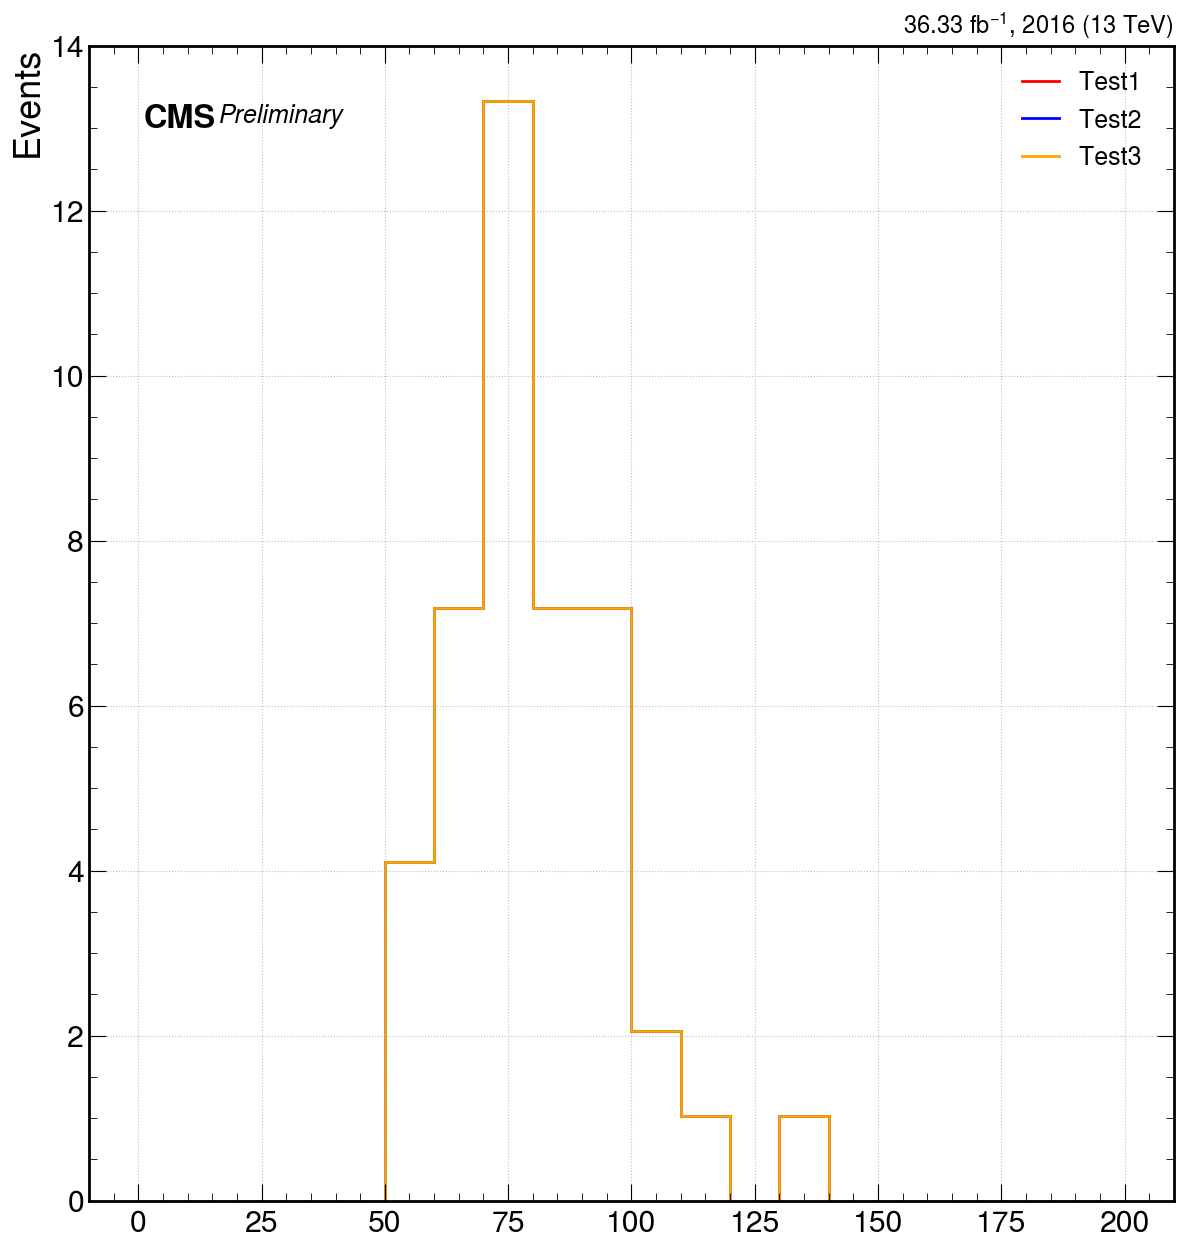

In [25]:
nbins, x_min, x_max = 20, 50, 250

plt.rcParams['axes.prop_cycle'] = cycler(color=["tab:blue",	"tab:orange",	"tab:green",	"tab:red",	"tab:purple", "tab:brown", "tab:pink", "k","tab:olive" ,	"tab:cyan"])

f = plt.figure(figsize=(14, 15))
ax = f.add_subplot(1, 1, 1)  
ax.grid()

year = "2016"
LUMI = {"2016APV": 36.33,"2016": 36.33, "2017": 41.48, "2018": 59.83,"Full-Run2":138}
hep.cms.label(loc = 1, data=True, year=year, ax=ax, lumi=LUMI[year], fontsize=18, llabel='Preliminary')

hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
hep.histplot(get_template(hists_template1["SR"],"s_w_matched_cb")[0], bins=get_template(hists_template1["SR"],"s_w_matched_cb")[2], label="Test1 ", histtype='step', stack=False, linewidth=2, ax=ax,color = "red")

hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
hep.histplot(get_template(hists_template1["SR"],"s_w_matched_cb")[0], bins=get_template(hists_template1["SR"],"s_w_matched_cb")[2], label="Test2 ", histtype='step', stack=False, linewidth=2, ax=ax,color = "blue")

hist_region = bh.Histogram(bh.axis.Regular(nbins, x_min, x_max), storage=bh.storage.Weight())
hep.histplot(get_template(hists_template1["SR"],"s_w_matched_cb")[0], bins=get_template(hists_template1["SR"],"s_w_matched_cb")[2], label="Test3 ", histtype='step', stack=False, linewidth=2, ax=ax,color = "orange")


ax.set_ylabel("Events")
ax.legend(loc="upper right", ncol=1, frameon=False, fontsize=18)
plt.show()